T1DM整体预测效果，最后部分放PPT

In [18]:
import os
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

In [3]:
# 定义数据文件夹路径
data_folder = 'T1DM'

# 初始化一个空的数据框
data = pd.DataFrame()

# 遍历文件夹中的每个Excel文件
for file in os.listdir(data_folder):
    if file.endswith('.xlsx'):
        file_path = os.path.join(data_folder, file)
        df = pd.read_excel(file_path)
        data = pd.concat([data, df], ignore_index=True)

# 查看合并后的数据
print(data.head())

                 Date  CGM (mg / dl)  Insulin dose - s.c.  \
0 2021-07-30 17:13:00          129.6                    0   
1 2021-07-30 17:28:00          142.2                    0   
2 2021-07-30 17:43:00          156.6                    0   
3 2021-07-30 17:58:00          162.0                    0   
4 2021-07-30 18:13:00          163.8                    0   

   Non-insulin hypoglycemic agents  CSII - bolus insulin (Novolin R, IU)  \
0                                0                                     0   
1                                0                                     0   
2                                0                                     0   
3                                0                                     0   
4                                0                                     0   

   Insulin dose - i.v.  take_food  Age (years)  Height (m)  Weight (kg)  ...  \
0                    0          1           66         1.5         60.0  ...   
1               

In [4]:
# 转换日期时间特征
data['Date'] = pd.to_datetime(data['Date'], format='%Y/%m/%d %H:%M:%S')
data['hour'] = data['Date'].dt.hour

# 处理缺失值
data.fillna(method='ffill', inplace=True)


C:\Users\17487\AppData\Local\Temp\ipykernel_32052\527943592.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [5]:
# 特征选择
features = ['Insulin dose - s.c.', 'Non-insulin hypoglycemic agents', 'CSII - bolus insulin (Novolin R, IU)',
            'Insulin dose - i.v.', 'take_food', 'Age (years)', 'Height (m)', 'Weight (kg)', 'BMI (kg/m2)',
            'Smoking History (pack year)', 'Alcohol Drinking History (drinker/non-drinker)', 'Type of Diabetes',
            'Duration of Diabetes (years)', 'Acute Diabetic Complications', 'Hypoglycemia (yes/no)', 'Gender (Female=0, Male=1)',
            'hour', 'CGM_lag1', 'CGM_lag2']

In [6]:
# 定义创建滞后特征的函数
def create_lagged_features(df, target_col, lags):
    for lag in lags:
        df[f'{target_col}_lag{lag}'] = df[target_col].shift(-lag)
    return df

# 创建目标标签
data = create_lagged_features(data, 'CGM (mg / dl)', lags=[15, 30, 45, 60])

# 去除包含NaN值的行（因为我们创建了滞后特征）
data.dropna(inplace=True)

In [7]:
# 初始化训练集和测试集
X_train = pd.DataFrame()
y_train = pd.DataFrame()
X_test = pd.DataFrame()
y_test = pd.DataFrame()

In [8]:
# 遍历每个文件，进行数据分割
for file in os.listdir(data_folder):
    if file.endswith('.xlsx'):
        file_path = os.path.join(data_folder, file)
        df = pd.read_excel(file_path)
        df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d %H:%M:%S')
        df['hour'] = df['Date'].dt.hour
        df = create_lagged_features(df, 'CGM (mg / dl)', lags=[15, 30, 45, 60])
        df.dropna(inplace=True)
        
        X_file = df[features]
        y_file = df[['CGM (mg / dl)_lag15', 'CGM (mg / dl)_lag30', 'CGM (mg / dl)_lag45', 'CGM (mg / dl)_lag60']]
        
        # 分割数据
        X_train = pd.concat([X_train, X_file.iloc[:-4, :]], ignore_index=True)
        y_train = pd.concat([y_train, y_file.iloc[:-4, :]], ignore_index=True)
        
        X_test = pd.concat([X_test, X_file.iloc[-4:, :]], ignore_index=True)
        y_test = pd.concat([y_test, y_file.iloc[-4:, :]], ignore_index=True)

In [9]:
# 处理分类特征（如果有）
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练集和测试集具有相同的列
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [13]:
# 创建预处理和模型管道
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), X_train.columns)
])

# 创建SVM回归模型
svm = SVR()

# 创建多输出回归器
multi_output_svr = MultiOutputRegressor(svm)

# 将预处理器和模型组成管道
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', multi_output_svr)
])

In [14]:
# 定义参数网格
param_grid = {
    'regressor__estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'regressor__estimator__C': [0.1, 1, 10, 100],
    'regressor__estimator__epsilon': [0.1, 0.2, 0.5, 1]
}

# 使用GridSearchCV进行参数调优
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 打印最佳参数
print("Best parameters found: ", grid_search.best_params_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best parameters found:  {'regressor__estimator__C': 0.1, 'regressor__estimator__epsilon': 0.1, 'regressor__estimator__kernel': 'sigmoid'}


In [15]:
# 使用最佳参数进行预测
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 评估模型性能
mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
print("Mean Absolute Error for each time interval: ", mae)

Mean Absolute Error for each time interval:  [47.36455181 44.38376449 55.29712483 62.66664197]


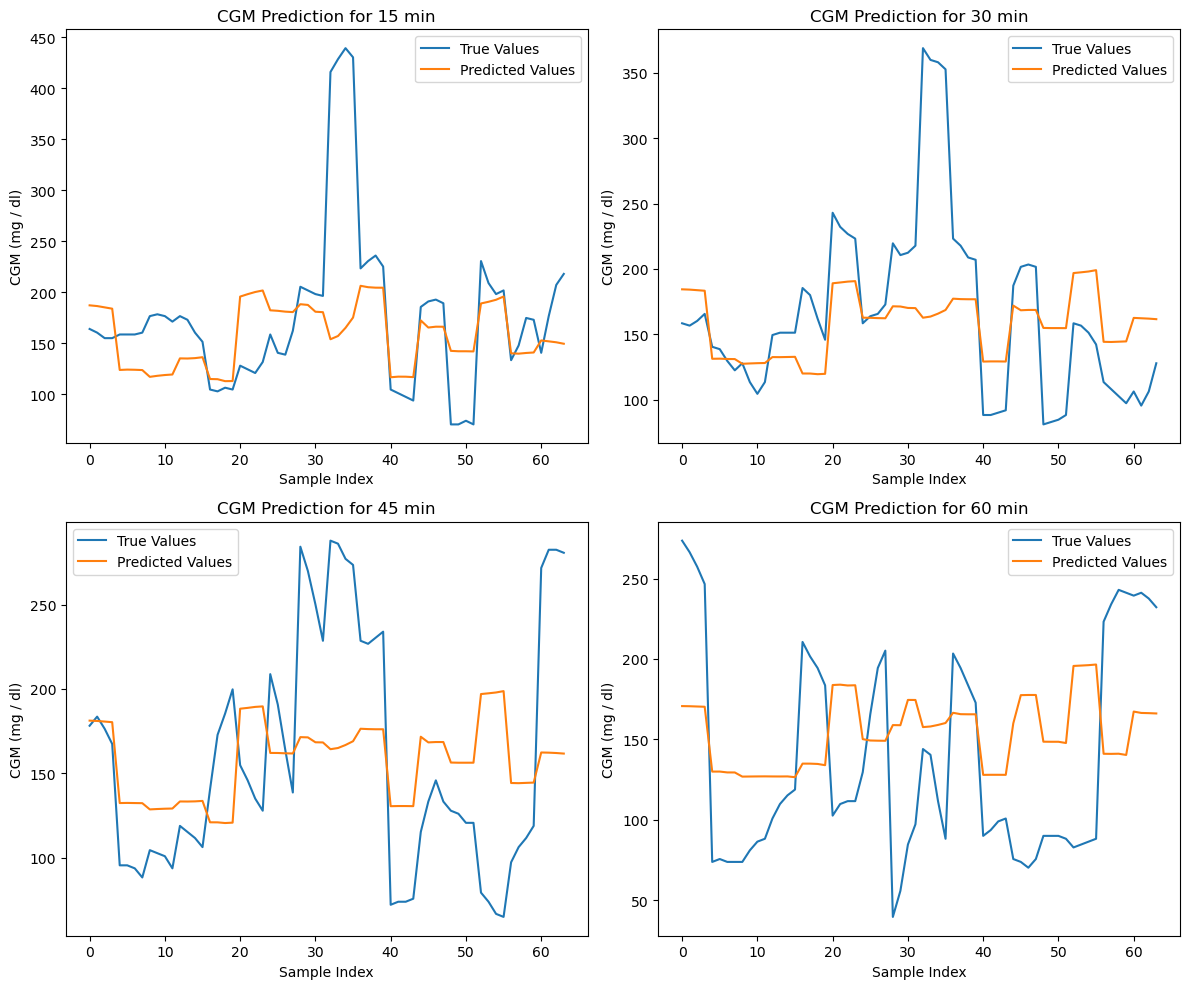

In [20]:
# 可视化预测结果
time_intervals = ['15 min', '30 min', '45 min', '60 min']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, ax in enumerate(axes.flat):
    ax.plot(y_test.iloc[:, i].values, label='True Values')
    ax.plot(y_pred[:, i], label='Predicted Values')
    ax.set_title(f'CGM Prediction for {time_intervals[i]}')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('CGM (mg / dl)')
    ax.legend()

plt.tight_layout()
plt.show()

T2DM整体预测效果，最后面的结果图放PPT

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

In [2]:
# 定义数据文件夹路径
data_folder = 'T2DM'

# 初始化一个空的数据框
data = pd.DataFrame()

# 遍历文件夹中的每个Excel文件
for file in os.listdir(data_folder):
    if file.endswith('.xlsx'):
        file_path = os.path.join(data_folder, file)
        df = pd.read_excel(file_path)
        data = pd.concat([data, df], ignore_index=True)

# 查看合并后的数据
print(data.head())

                 Date  CGM (mg / dl)  Insulin dose - s.c.  \
0 2020-12-30 14:24:00          106.2                    0   
1 2020-12-30 14:39:00           97.2                    0   
2 2020-12-30 14:54:00           88.2                    0   
3 2020-12-30 15:09:00           75.6                    0   
4 2020-12-30 15:24:00           64.8                    0   

   Non-insulin hypoglycemic agents  CSII - bolus insulin (Novolin R, IU)  \
0                                0                                     0   
1                                0                                     0   
2                                0                                     0   
3                                0                                     0   
4                                0                                     0   

   Insulin dose - i.v.  take_food  Age (years)  Height (m)  Weight (kg)  ...  \
0                    0          0           57        1.69         67.4  ...   
1               

In [3]:
# 转换日期时间特征
data['Date'] = pd.to_datetime(data['Date'], format='%Y/%m/%d %H:%M:%S')
data['hour'] = data['Date'].dt.hour

# 处理缺失值
data.fillna(method='ffill', inplace=True)


C:\Users\17487\AppData\Local\Temp\ipykernel_1032\527943592.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [4]:
# 特征选择
features = ['Insulin dose - s.c.', 'Non-insulin hypoglycemic agents', 'CSII - bolus insulin (Novolin R, IU)',
            'Insulin dose - i.v.', 'take_food', 'Age (years)', 'Height (m)', 'Weight (kg)', 'BMI (kg/m2)',
            'Smoking History (pack year)', 'Alcohol Drinking History (drinker/non-drinker)', 'Type of Diabetes',
            'Duration of diabetes (years)', 'Acute Diabetic Complications', 'Hypoglycemia (yes/no)', 'Gender (Female=0, Male=1)',
            'hour', 'CGM_lag1', 'CGM_lag2']

In [5]:
# 定义创建滞后特征的函数
def create_lagged_features(df, target_col, lags):
    for lag in lags:
        df[f'{target_col}_lag{lag}'] = df[target_col].shift(-lag)
    return df

# 创建目标标签
data = create_lagged_features(data, 'CGM (mg / dl)', lags=[15, 30, 45, 60])

# 去除包含NaN值的行（因为我们创建了滞后特征）
data.dropna(inplace=True).


In [6]:
# 初始化训练集和测试集
X_train = pd.DataFrame()
y_train = pd.DataFrame()
X_test = pd.DataFrame()
y_test = pd.DataFrame()

In [7]:
# 遍历每个文件，进行数据分割
for file in os.listdir(data_folder):
    if file.endswith('.xlsx'):
        file_path = os.path.join(data_folder, file)
        df = pd.read_excel(file_path)
        df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d %H:%M:%S')
        df['hour'] = df['Date'].dt.hour
        df = create_lagged_features(df, 'CGM (mg / dl)', lags=[15, 30, 45, 60])
        df.dropna(inplace=True)
        
        X_file = df[features]
        y_file = df[['CGM (mg / dl)_lag15', 'CGM (mg / dl)_lag30', 'CGM (mg / dl)_lag45', 'CGM (mg / dl)_lag60']]
        
        # 分割数据
        X_train = pd.concat([X_train, X_file.iloc[:-4, :]], ignore_index=True)
        y_train = pd.concat([y_train, y_file.iloc[:-4, :]], ignore_index=True)
        
        X_test = pd.concat([X_test, X_file.iloc[-4:, :]], ignore_index=True)
        y_test = pd.concat([y_test, y_file.iloc[-4:, :]], ignore_index=True)

In [8]:
# 处理分类特征（如果有）
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练集和测试集具有相同的列
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [9]:
# 创建SVM回归模型
svm = SVR(kernel='rbf')

# 创建多输出回归器
model = MultiOutputRegressor(svm)

# 标准化数据
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 训练模型
model.fit(X_train_scaled, y_train)

# 进行预测
y_pred = model.predict(X_test_scaled)

# 评估模型性能
mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
print("Mean Absolute Error for each time interval: ", ·mae)



Mean Absolute Error for each time interval:  [28.37003607 25.05599569 30.27658962 36.70755367]


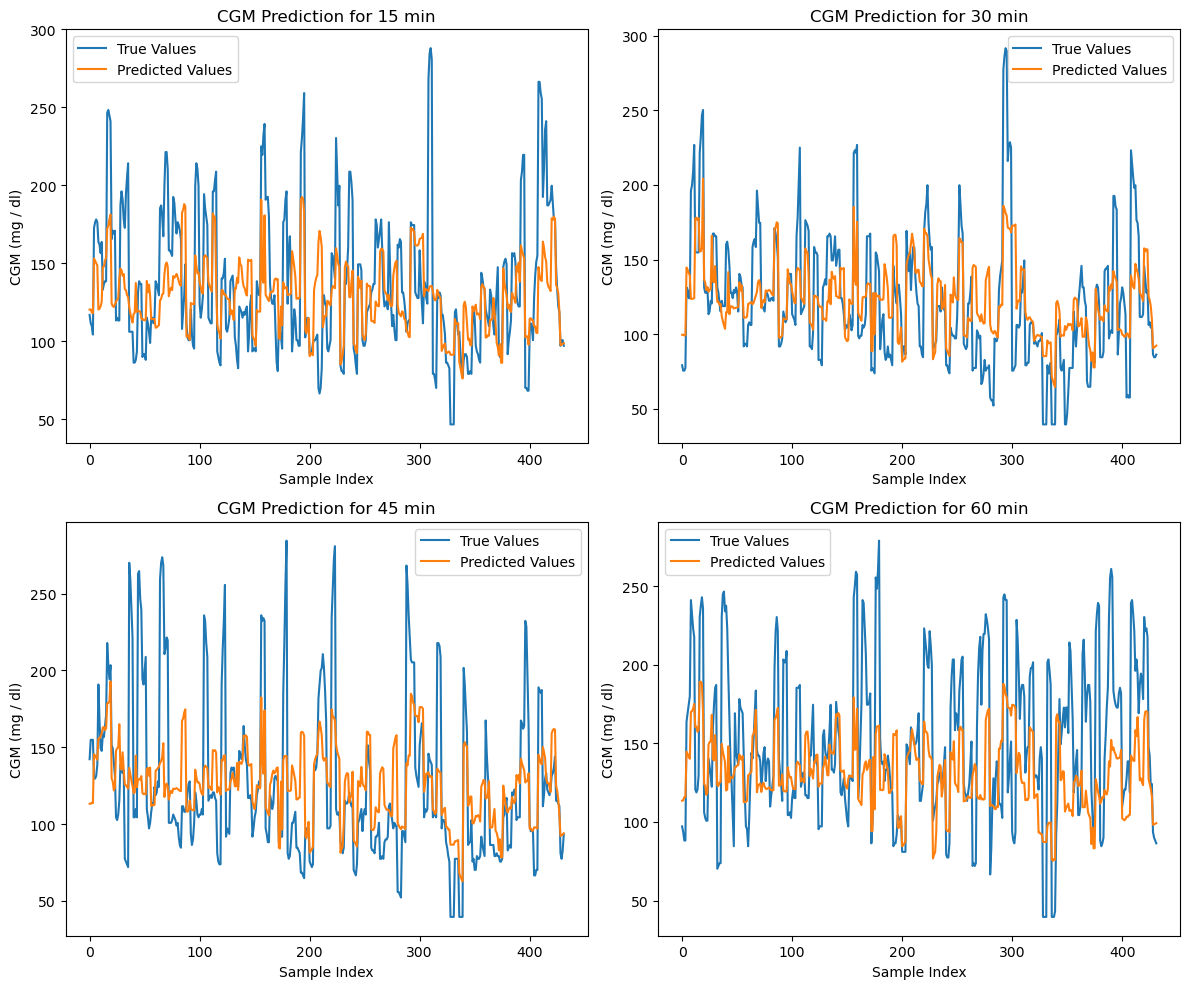

In [10]:
# 可视化预测结果
time_intervals = ['15 min', '30 min', '45 min', '60 min']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, ax in enumerate(axes.flat):
    ax.plot(y_test.iloc[:, i].values, label='True Values')
    ax.plot(y_pred[:, i], label='Predicted Values')
    ax.set_title(f'CGM Prediction for {time_intervals[i]}')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('CGM (mg / dl)')
    ax.legend()

plt.tight_layout()
plt.show()

特征重要性1完整代码——lstm实现

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import os
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

In [4]:
# 定义数据文件夹路径
data_folder = 'T1DM'

# 初始化一个空的数据框
data = pd.DataFrame()

# 遍历文件夹中的每个Excel文件
for file in os.listdir(data_folder):
    if file.endswith('.xlsx'):
        file_path = os.path.join(data_folder, file)
        df = pd.read_excel(file_path)
        data = pd.concat([data, df], ignore_index=True)

# 转换日期时间特征
data['Date'] = pd.to_datetime(data['Date'], format='%Y/%m/%d %H:%M:%S')
data['hour'] = data['Date'].dt.hour

# 处理缺失值
data.fillna(method='ffill', inplace=True)


C:\Users\17487\AppData\Local\Temp\ipykernel_17684\846515586.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [5]:
# 特征选择
features = ['Insulin dose - s.c.', 'Non-insulin hypoglycemic agents', 'CSII - bolus insulin (Novolin R, IU)',
            'Insulin dose - i.v.', 'take_food', 'Age (years)', 'Height (m)', 'Weight (kg)', 'BMI (kg/m2)',
            'Smoking History (pack year)', 'Alcohol Drinking History (drinker/non-drinker)', 'Type of Diabetes',
            'Duration of Diabetes (years)', 'Acute Diabetic Complications', 'Hypoglycemia (yes/no)', 'Gender (Female=0, Male=1)',
            'hour', 'CGM_lag1', 'CGM_lag2']

# 定义创建滞后特征的函数
def create_lagged_features(df, target_col, lags):
    for lag in lags:
        df[f'{target_col}_lag{lag}'] = df[target_col].shift(-lag)
    return df

# 创建目标标签
data = create_lagged_features(data, 'CGM (mg / dl)', lags=[15, 30, 45, 60])

# 去除包含NaN值的行（因为我们创建了滞后特征）
data.dropna(inplace=True)


In [6]:
# 初始化训练集和测试集
X_train = pd.DataFrame()
y_train = pd.DataFrame()
X_test = pd.DataFrame()
y_test = pd.DataFrame()

# 遍历每个文件，进行数据分割
for file in os.listdir(data_folder):
    if file.endswith('.xlsx'):
        file_path = os.path.join(data_folder, file)
        df = pd.read_excel(file_path)
        df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d %H:%M:%S')
        df['hour'] = df['Date'].dt.hour
        df = create_lagged_features(df, 'CGM (mg / dl)', lags=[15, 30, 45, 60])
        df.dropna(inplace=True)
        
        X_file = df[features]
        y_file = df[['CGM (mg / dl)_lag15', 'CGM (mg / dl)_lag30', 'CGM (mg / dl)_lag45', 'CGM (mg / dl)_lag60']]
        
        # 分割数据
        X_train = pd.concat([X_train, X_file.iloc[:-4, :]], ignore_index=True)
        y_train = pd.concat([y_train, y_file.iloc[:-4, :]], ignore_index=True)
        
        X_test = pd.concat([X_test, X_file.iloc[-4:, :]], ignore_index=True)
        y_test = pd.concat([y_test, y_file.iloc[-4:, :]], ignore_index=True)

# 处理分类特征（如果有）
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练集和测试集具有相同的列
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)


In [8]:
# 标准化数据
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 将数据转换为适合LSTM输入的形状 (samples, timesteps, features)
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y.iloc[i + time_steps].values)  # 确保y是pandas DataFrame，使用values转换为numpy array
    return np.array(Xs), np.array(ys)

time_steps = 1
X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train, time_steps)
X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, y_test, time_steps)

In [9]:
# 创建LSTM模型
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, X_train_lstm.shape[2])))
model.add(Dense(4))  # 对应4个时间步的输出
model.compile(optimizer='adam', loss='mae')

D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# 定义早停法
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# 训练模型
history = model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, 
                    validation_split=0.2, callbacks=[early_stop], verbose=1)

# 进行预测
y_pred_lstm = model.predict(X_test_lstm)


Epoch 1/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 158.4916 - val_loss: 159.2895
Epoch 2/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 106.9870 - val_loss: 113.6046
Epoch 3/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 62.0196 - val_loss: 94.4573
Epoch 4/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 54.4163 - val_loss: 93.7488
Epoch 5/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 52.6287 - val_loss: 95.4623
Epoch 6/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 51.7126 - val_loss: 98.0722
Epoch 7/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 50.7423 - val_loss: 101.5025
Epoch 8/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 50.2425 - val_loss: 103.7112
Epoch 9/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 49.8427 - val_loss: 105.7624
Epoch 10/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 49.4897 - val_loss: 106.9618
Epoch 11/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 49.4527 - val_loss: 108.1212
Epoch 12/50
366/366 ━

In [11]:
# 评估模型性能
mae = mean_absolute_error(y_test_lstm, y_pred_lstm, multioutput='raw_values')
print("Mean Absolute Error for each time interval: ", mae)


Mean Absolute Error for each time interval:  [63.83906142 48.83307547 53.43982392 61.0286828 ]


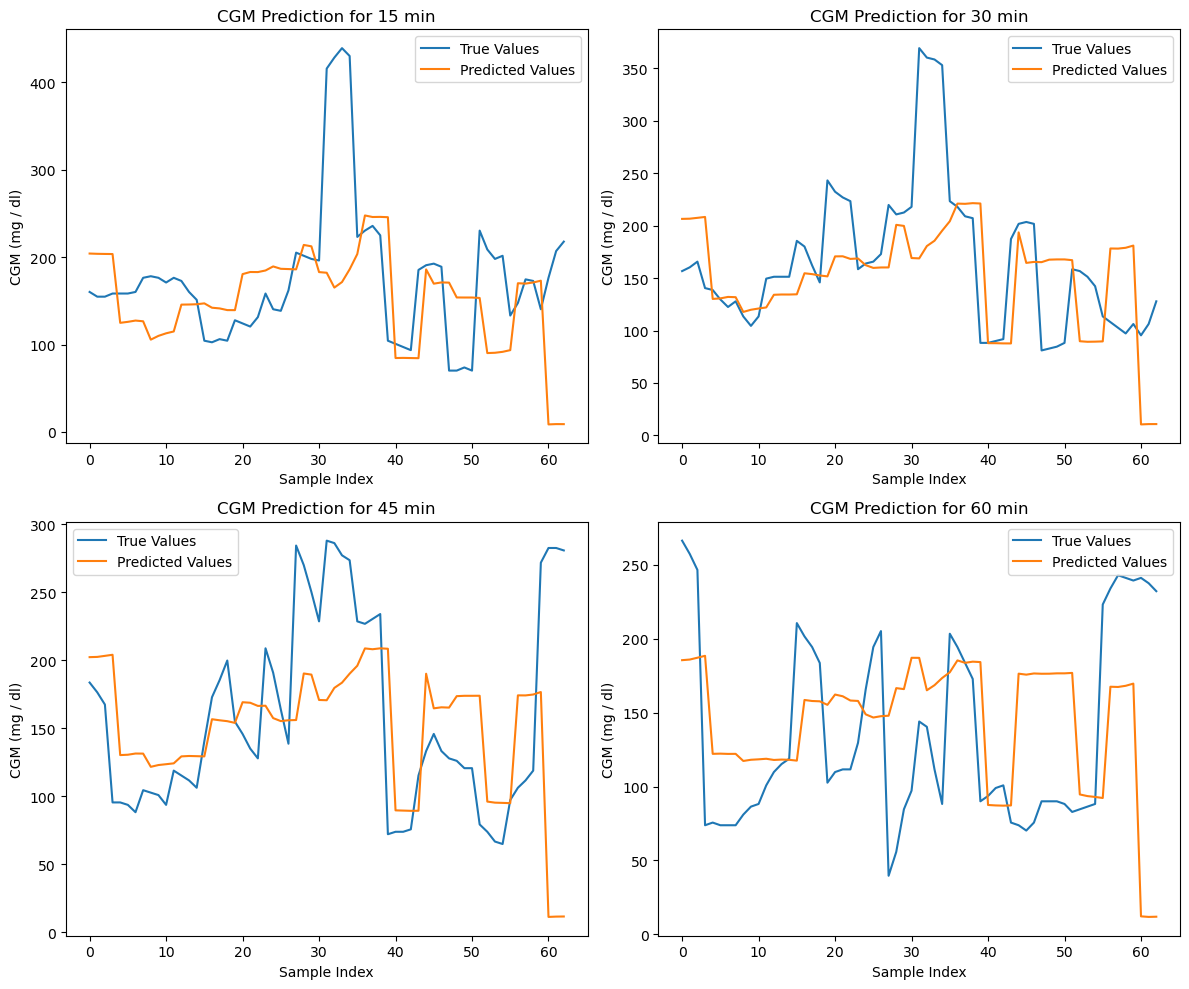

In [12]:
# 可视化预测结果
time_intervals = ['15 min', '30 min', '45 min', '60 min']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, ax in enumerate(axes.flat):
    ax.plot(y_test_lstm[:, i], label='True Values')
    ax.plot(y_pred_lstm[:, i], label='Predicted Values')
    ax.set_title(f'CGM Prediction for {time_intervals[i]}')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('CGM (mg / dl)')
    ax.legend()

plt.tight_layout()
plt.show()

特征重要性1用于PPT部分——lstm实现

In [15]:
# 计算特征重要性
def compute_feature_importance(model, X_test, y_test, X_train, time_steps):
    baseline_mae = mean_absolute_error(y_test, model.predict(X_test))
    feature_importance = {}

    for col in range(X_train.shape[1]):
        X_permuted = X_test.copy()
        np.random.shuffle(X_permuted[:, :, col])

        permuted_mae = mean_absolute_error(y_test, model.predict(X_permuted))
        feature_importance[X_train.columns[col]] = permuted_mae - baseline_mae

    return feature_importance

X_test_lstm_reshaped = X_test_lstm.reshape(X_test_lstm.shape[0], time_steps, X_test_lstm.shape[2])
feature_importance = compute_feature_importance(model, X_test_lstm_reshaped, y_test_lstm, X_train, time_steps)

# 打印特征重要性
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_importance:
    print(f'Feature: {feature}, Importance: {importance}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Feature: Hypoglycemia (yes/no), Importance: 8.536023330310044
Feature: Weight (kg), Importance: 7.710996857522034
Feature: Gender (Female=0, Male=1), Importance: 6.4083203989361905
Feature: Alcohol Drinking History (drinker/non-drinker), Im

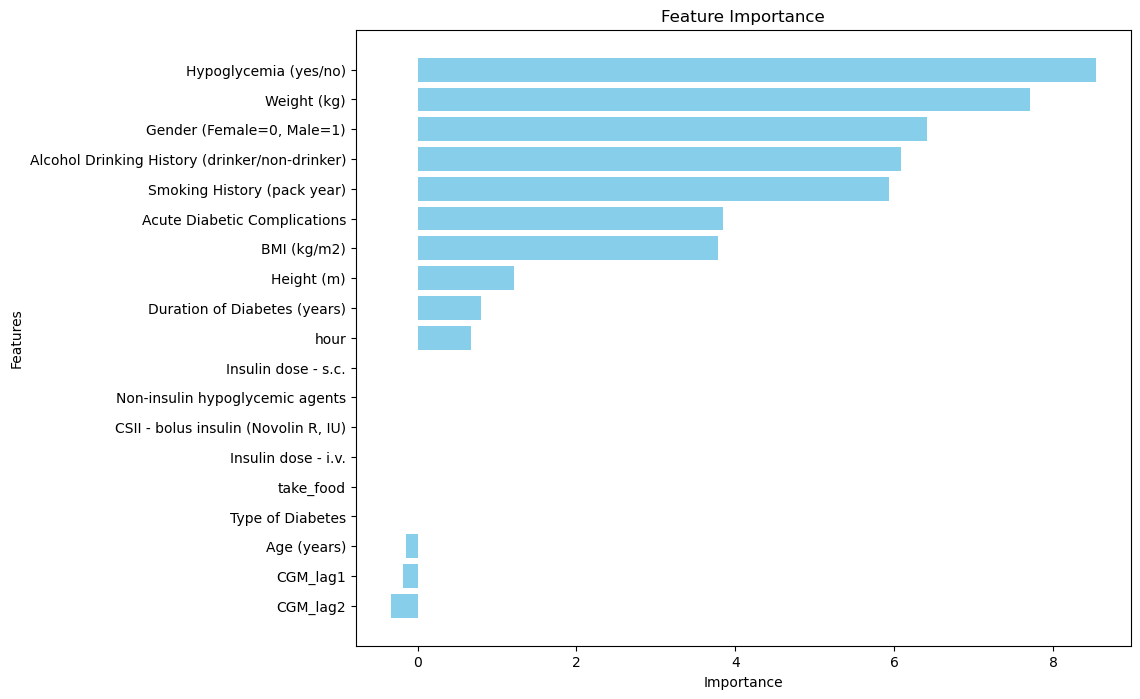

In [16]:
# 可视化特征重要性
def plot_feature_importance(feature_importance):
    features = [item[0] for item in feature_importance]
    importances = [item[1] for item in feature_importance]

    plt.figure(figsize=(8,3))
    plt.barh(features, importances, color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()  # 反转y轴，让重要性高的排在上面
    plt.show()

# 调用可视化函数
plot_feature_importance(sorted_importance)

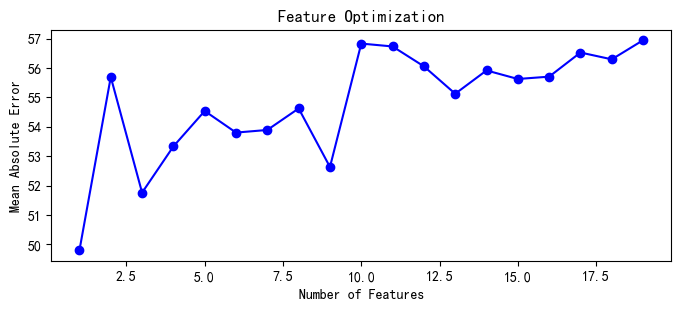

In [22]:
# 可视化特征优化结果
def plot_optimization_results(results):
    feature_counts = [item[0] for item in results]
    maes = [item[1] for item in results]

    plt.figure(figsize=(8, 3))
    plt.plot(feature_counts, maes, marker='o', linestyle='-', color='b')
    plt.title('Feature Optimization')
    plt.xlabel('Number of Features')
    plt.ylabel('Mean Absolute Error')
    plt.show()

plot_optimization_results(optimization_results)

特征重要性1用于PPT到此结束，上面有完整代码，可以用GPT问实现的思路

C:\Users\17487\AppData\Local\Temp\ipykernel_1472\3746233278.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


Epoch 1/50


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 158.6737 - val_loss: 158.9047
Epoch 2/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 105.1409 - val_loss: 110.7572
Epoch 3/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 61.2933 - val_loss: 94.6153
Epoch 4/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 54.0502 - val_loss: 93.9196
Epoch 5/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 51.7487 - val_loss: 96.0016
Epoch 6/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 51.7649 - val_loss: 99.9084
Epoch 7/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 50.7001 - val_loss: 104.1666
Epoch 8/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 49.9676 - val_loss: 106.5350
Epoch 9/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 49.6362 - val_loss: 108.7833
Epoch 10/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 49.2966 - val_loss: 108.8056
Epoch 11/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 49.1966 - val_loss: 109.7751
Epoch 12/50
366/366 ━━━━━━━━━━━━

D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


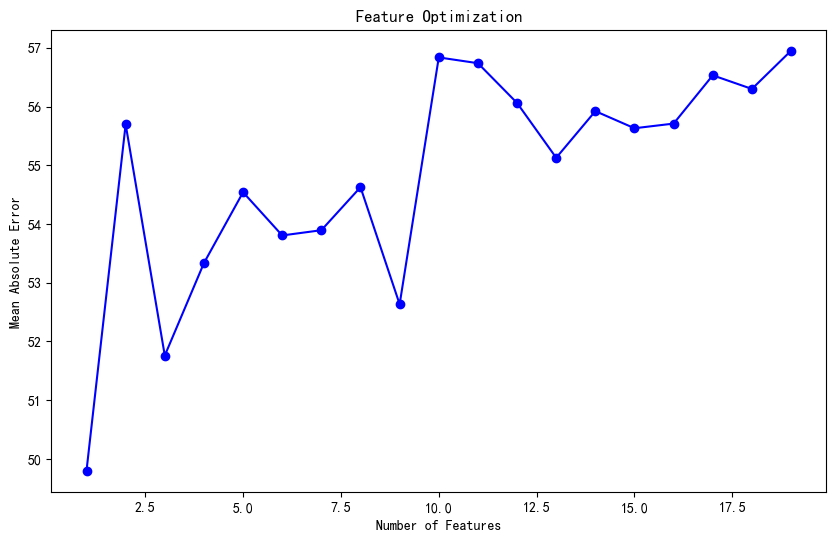

In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os

# 定义数据文件夹路径
data_folder = 'T1DM'

# 初始化一个空的数据框
data = pd.DataFrame()

# 遍历文件夹中的每个Excel文件
for file in os.listdir(data_folder):
    if file.endswith('.xlsx'):
        file_path = os.path.join(data_folder, file)
        df = pd.read_excel(file_path)
        data = pd.concat([data, df], ignore_index=True)

# 转换日期时间特征
data['Date'] = pd.to_datetime(data['Date'], format='%Y/%m/%d %H:%M:%S')
data['hour'] = data['Date'].dt.hour

# 处理缺失值
data.fillna(method='ffill', inplace=True)

# 特征选择
features = ['Insulin dose - s.c.', 'Non-insulin hypoglycemic agents', 'CSII - bolus insulin (Novolin R, IU)',
            'Insulin dose - i.v.', 'take_food', 'Age (years)', 'Height (m)', 'Weight (kg)', 'BMI (kg/m2)',
            'Smoking History (pack year)', 'Alcohol Drinking History (drinker/non-drinker)', 'Type of Diabetes',
            'Duration of Diabetes (years)', 'Acute Diabetic Complications', 'Hypoglycemia (yes/no)', 'Gender (Female=0, Male=1)',
            'hour', 'CGM_lag1', 'CGM_lag2']

# 定义创建滞后特征的函数
def create_lagged_features(df, target_col, lags):
    for lag in lags:
        df[f'{target_col}_lag{lag}'] = df[target_col].shift(-lag)
    return df

# 创建目标标签
data = create_lagged_features(data, 'CGM (mg / dl)', lags=[15, 30, 45, 60])

# 去除包含NaN值的行（因为我们创建了滞后特征）
data.dropna(inplace=True)

# 初始化训练集和测试集
X_train = pd.DataFrame()
y_train = pd.DataFrame()
X_test = pd.DataFrame()
y_test = pd.DataFrame()

# 遍历每个文件，进行数据分割
for file in os.listdir(data_folder):
    if file.endswith('.xlsx'):
        file_path = os.path.join(data_folder, file)
        df = pd.read_excel(file_path)
        df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d %H:%M:%S')
        df['hour'] = df['Date'].dt.hour
        df = create_lagged_features(df, 'CGM (mg / dl)', lags=[15, 30, 45, 60])
        df.dropna(inplace=True)
        
        X_file = df[features]
        y_file = df[['CGM (mg / dl)_lag15', 'CGM (mg / dl)_lag30', 'CGM (mg / dl)_lag45', 'CGM (mg / dl)_lag60']]
        
        # 分割数据
        X_train = pd.concat([X_train, X_file.iloc[:-4, :]], ignore_index=True)
        y_train = pd.concat([y_train, y_file.iloc[:-4, :]], ignore_index=True)
        
        X_test = pd.concat([X_test, X_file.iloc[-4:, :]], ignore_index=True)
        y_test = pd.concat([y_test, y_file.iloc[-4:, :]], ignore_index=True)

# 处理分类特征（如果有）
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练集和测试集具有相同的列
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# 标准化数据
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 将数据转换为适合LSTM输入的形状 (samples, timesteps, features)
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 1
X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train, time_steps)
X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, y_test, time_steps)

# 创建LSTM模型
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, X_train_lstm.shape[2])))
model.add(Dense(4))  # 对应4个时间步的输出
model.compile(optimizer='adam', loss='mae')

# 定义早停法
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# 训练模型
history = model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, 
                    validation_split=0.2, callbacks=[early_stop], verbose=1)

# 进行预测
y_pred_lstm = model.predict(X_test_lstm)

# 评估模型性能
mae = mean_absolute_error(y_test_lstm, y_pred_lstm, multioutput='raw_values')
print("Mean Absolute Error for each time interval: ", mae)

# 计算特征重要性
def compute_feature_importance(model, X_test, y_test, X_train, time_steps):
    baseline_mae = mean_absolute_error(y_test, model.predict(X_test))
    feature_importance = {}

    for col in range(X_train.shape[1]):
        X_permuted = X_test.copy()
        np.random.shuffle(X_permuted[:, :, col])

        permuted_mae = mean_absolute_error(y_test, model.predict(X_permuted))
        feature_importance[X_train.columns[col]] = permuted_mae - baseline_mae

    return feature_importance

X_test_lstm_reshaped = X_test_lstm.reshape(X_test_lstm.shape[0], time_steps, X_test_lstm.shape[2])
feature_importance = compute_feature_importance(model, X_test_lstm_reshaped, y_test_lstm, X_train, time_steps)

# 打印特征重要性
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_importance:
    print(f'Feature: {feature}, Importance: {importance}')

# 进行特征优化
def feature_optimization(X_train, X_test, y_train, y_test, sorted_importance, time_steps=1):
    results = []

    for i in range(1, len(sorted_importance) + 1):
        selected_features = [feature[0] for feature in sorted_importance[:i]]
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]

        # 标准化数据
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_selected)
        X_test_scaled = scaler.transform(X_test_selected)

        # 将数据转换为适合LSTM输入的形状 (samples, timesteps, features)
        X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train, time_steps)
        X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, y_test, time_steps)

        # 创建LSTM模型
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(time_steps, X_train_lstm.shape[2])))
        model.add(Dense(4))  # 对应4个时间步的输出
        model.compile(optimizer='adam', loss='mae')

        # 训练模型
        history = model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, 
                            validation_split=0.2, callbacks=[early_stop], verbose=0)

        # 进行预测
        y_pred_lstm = model.predict(X_test_lstm)

        # 评估模型性能
        mae = mean_absolute_error(y_test_lstm, y_pred_lstm, multioutput='raw_values')
        results.append((i, mae.mean()))

    return results

optimization_results = feature_optimization(X_train, X_test, y_train, y_test, sorted_importance, time_steps)

# 可视化特征优化结果
def plot_optimization_results(results):
    feature_counts = [item[0] for item in results]
    maes = [item[1] for item in results]

    plt.figure(figsize=(10, 6))
    plt.plot(feature_counts, maes, marker='o', linestyle='-', color='b')
    plt.title('Feature Optimization')
    plt.xlabel('Number of Features')
    plt.ylabel('Mean Absolute Error')
    plt.show()

plot_optimization_results(optimization_results)


In [20]:
# 打印特征重要性
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_importance:
    print(f'Feature: {feature}, Importance: {importance}')

Feature: Weight (kg), Importance: 9.988713318204127
Feature: Alcohol Drinking History (drinker/non-drinker), Importance: 7.6114567249540315
Feature: Hypoglycemia (yes/no), Importance: 6.437731697824269
Feature: Gender (Female=0, Male=1), Importance: 5.055487818188141
Feature: BMI (kg/m2), Importance: 4.689055513957193
Feature: Smoking History (pack year), Importance: 4.658535577002034
Feature: Duration of Diabetes (years), Importance: 3.2286888523707304
Feature: Height (m), Importance: 2.360902155770198
Feature: hour, Importance: 1.1757087018754717
Feature: Acute Diabetic Complications, Importance: 0.6453419918105681
Feature: Age (years), Importance: 0.5410100475190163
Feature: CGM_lag1, Importance: 0.291577417888341
Feature: Insulin dose - s.c., Importance: 0.0
Feature: Non-insulin hypoglycemic agents, Importance: 0.0
Feature: CSII - bolus insulin (Novolin R, IU), Importance: 0.0
Feature: Insulin dose - i.v., Importance: 0.0
Feature: take_food, Importance: 0.0
Feature: Type of Diabete

特征重要性实现方法2——完整代码——lstm实现从此开始

C:\Users\17487\AppData\Local\Temp\ipykernel_1472\3763724568.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


Epoch 1/50


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 159.5669 - val_loss: 160.2203
Epoch 2/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 111.9381 - val_loss: 112.3919
Epoch 3/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 63.8951 - val_loss: 96.2061
Epoch 4/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 54.3596 - val_loss: 95.0914
Epoch 5/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 52.1317 - val_loss: 96.4939
Epoch 6/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 51.8078 - val_loss: 100.1286
Epoch 7/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 50.7641 - val_loss: 103.3056
Epoch 8/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 50.3979 - val_loss: 106.3237
Epoch 9/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 49.6157 - val_loss: 107.9352
Epoch 10/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 49.6610 - val_loss: 109.5538
Epoch 11/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 49.5611 - val_loss: 110.5374
Epoch 12/50
366/366 ━━━━━━━━━━━

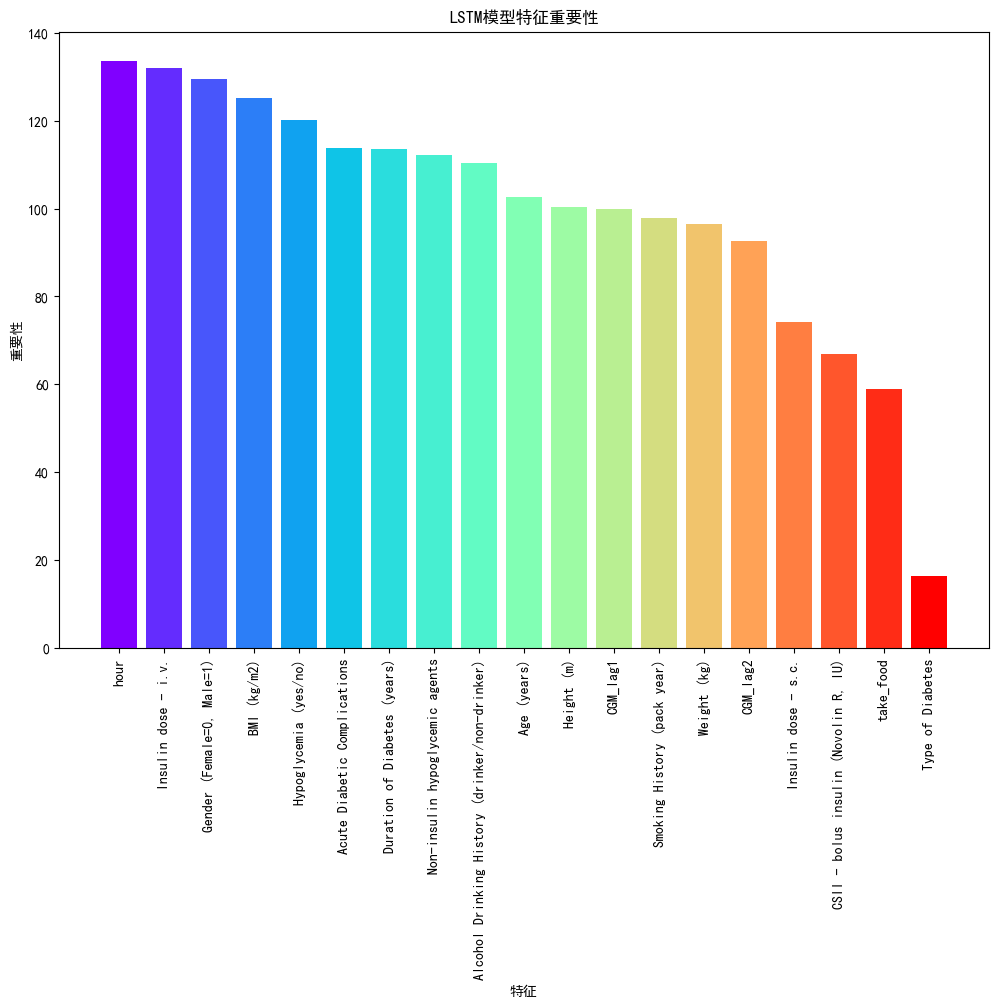

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002749FDC3D80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
各时间间隔的平均绝对误差:  [63.73279096 48.18437171 52.25684805 62.4814408 ]


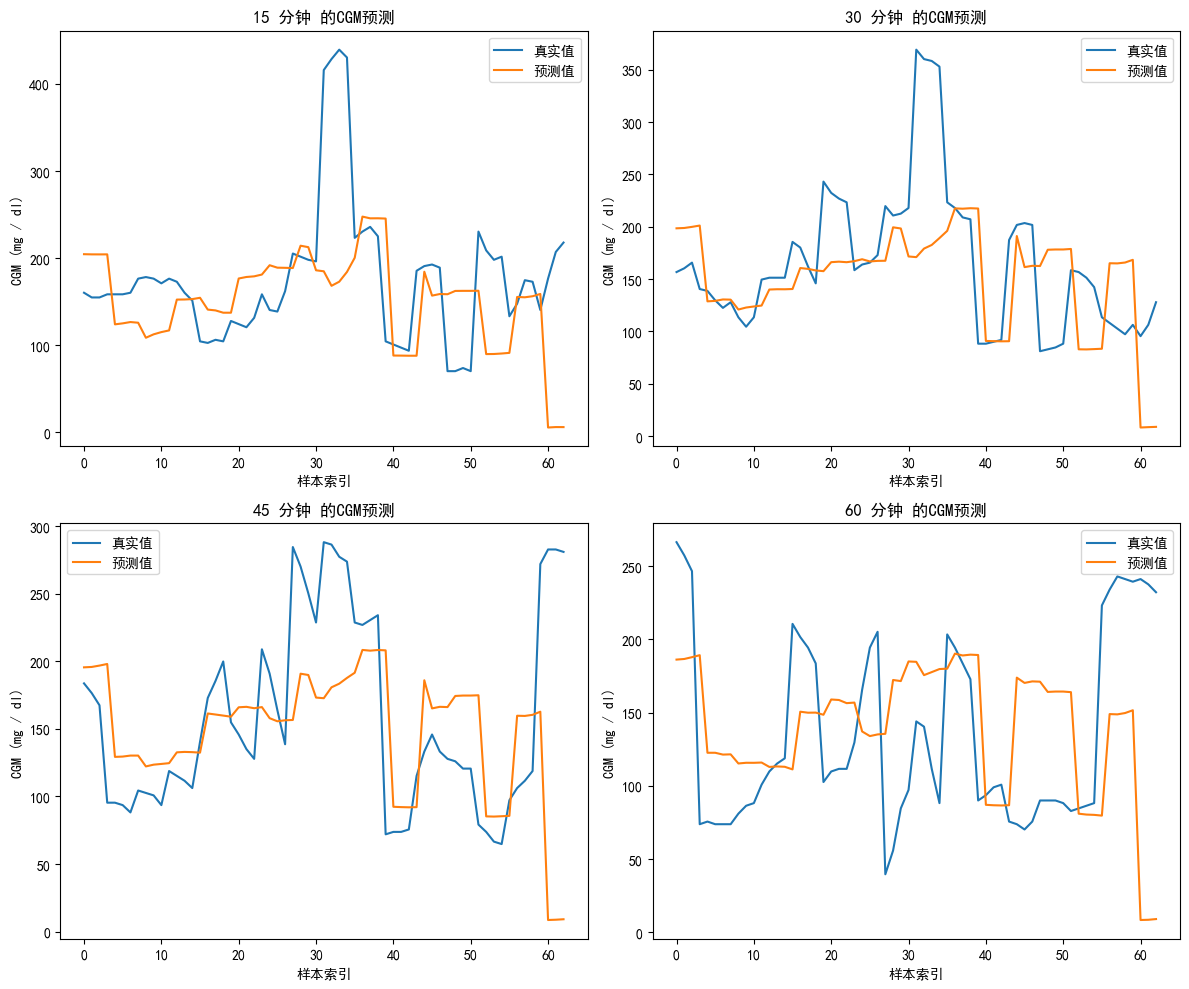

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import os
import pandas as pd

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

# 定义数据文件夹路径
data_folder = 'T1DM'

# 初始化一个空的数据框
data = pd.DataFrame()

# 遍历文件夹中的每个Excel文件
for file in os.listdir(data_folder):
    if file.endswith('.xlsx'):
        file_path = os.path.join(data_folder, file)
        df = pd.read_excel(file_path)
        data = pd.concat([data, df], ignore_index=True)

# 转换日期时间特征
data['Date'] = pd.to_datetime(data['Date'], format='%Y/%m/%d %H:%M:%S')
data['hour'] = data['Date'].dt.hour

# 处理缺失值
data.fillna(method='ffill', inplace=True)

# 特征选择
features = ['Insulin dose - s.c.', 'Non-insulin hypoglycemic agents', 'CSII - bolus insulin (Novolin R, IU)',
            'Insulin dose - i.v.', 'take_food', 'Age (years)', 'Height (m)', 'Weight (kg)', 'BMI (kg/m2)',
            'Smoking History (pack year)', 'Alcohol Drinking History (drinker/non-drinker)', 'Type of Diabetes',
            'Duration of Diabetes (years)', 'Acute Diabetic Complications', 'Hypoglycemia (yes/no)', 'Gender (Female=0, Male=1)',
            'hour', 'CGM_lag1', 'CGM_lag2']

# 定义创建滞后特征的函数
def create_lagged_features(df, target_col, lags):
    for lag in lags:
        df[f'{target_col}_lag{lag}'] = df[target_col].shift(-lag)
    return df

# 创建目标标签
data = create_lagged_features(data, 'CGM (mg / dl)', lags=[15, 30, 45, 60])

# 去除包含NaN值的行（因为我们创建了滞后特征）
data.dropna(inplace=True)

# 初始化训练集和测试集
X_train = pd.DataFrame()
y_train = pd.DataFrame()
X_test = pd.DataFrame()
y_test = pd.DataFrame()

# 遍历每个文件，进行数据分割
for file in os.listdir(data_folder):
    if file.endswith('.xlsx'):
        file_path = os.path.join(data_folder, file)
        df = pd.read_excel(file_path)
        df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d %H:%M:%S')
        df['hour'] = df['Date'].dt.hour
        df = create_lagged_features(df, 'CGM (mg / dl)', lags=[15, 30, 45, 60])
        df.dropna(inplace=True)
        
        X_file = df[features]
        y_file = df[['CGM (mg / dl)_lag15', 'CGM (mg / dl)_lag30', 'CGM (mg / dl)_lag45', 'CGM (mg / dl)_lag60']]
        
        # 分割数据
        X_train = pd.concat([X_train, X_file.iloc[:-4, :]], ignore_index=True)
        y_train = pd.concat([y_train, y_file.iloc[:-4, :]], ignore_index=True)
        
        X_test = pd.concat([X_test, X_file.iloc[-4:, :]], ignore_index=True)
        y_test = pd.concat([y_test, y_file.iloc[-4:, :]], ignore_index=True)

# 处理分类特征（如果有）
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练集和测试集具有相同的列
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# 标准化数据
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 将数据转换为适合LSTM输入的形状 (samples, timesteps, features)
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y.iloc[i + time_steps].values)  # 确保y是pandas DataFrame，使用values转换为numpy array
    return np.array(Xs), np.array(ys)

time_steps = 1
X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train, time_steps)
X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, y_test, time_steps)

# 创建LSTM模型
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, X_train_lstm.shape[2])))
model.add(Dense(4))  # 对应4个时间步的输出
model.compile(optimizer='adam', loss='mae')

# 定义早停法
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# 训练模型
history = model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, 
                    validation_split=0.2, callbacks=[early_stop], verbose=1)

# 提取LSTM层权重
lstm_layer = model.layers[0]
weights = lstm_layer.get_weights()[0]  # 获取LSTM层的输入权重

# 聚合权重以获取特征重要性
feature_importance = np.abs(weights).sum(axis=1)

# 特征名称按照重要性排序
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_features = [features[i] for i in sorted_indices]
sorted_importance = feature_importance[sorted_indices]

# 打印特征重要性
print("特征重要性：")
for feat, importance in zip(sorted_features, sorted_importance):
    print(f"{feat}: {importance:.4f}")

# 可视化特征重要性
colors = cm.rainbow(np.linspace(0, 1, len(sorted_features)))
plt.figure(figsize=(12, 8))
plt.bar(sorted_features, sorted_importance, color=colors)
plt.xlabel('特征')
plt.ylabel('重要性')
plt.title('LSTM模型特征重要性')
plt.xticks(rotation=90)  # 使特征名称可以清晰显示
plt.show()

# 进行预测
y_pred_lstm = model.predict(X_test_lstm)




特征重要性实现方法2——用于PPT部分从此开始

特征重要性：
hour: 133.6079
Insulin dose - i.v.: 132.0041
Gender (Female=0, Male=1): 129.4496
BMI (kg/m2): 125.2553
Hypoglycemia (yes/no): 120.2890
Acute Diabetic Complications: 113.7989
Duration of Diabetes (years): 113.6140
Non-insulin hypoglycemic agents: 112.3127
Alcohol Drinking History (drinker/non-drinker): 110.3280
Age (years): 102.7172
Height (m): 100.3008
CGM_lag1: 99.8955
Smoking History (pack year): 97.7668
Weight (kg): 96.6109
CGM_lag2: 92.7462
Insulin dose - s.c.: 74.2453
CSII - bolus insulin (Novolin R, IU): 66.9481
take_food: 59.0098
Type of Diabetes: 16.4436


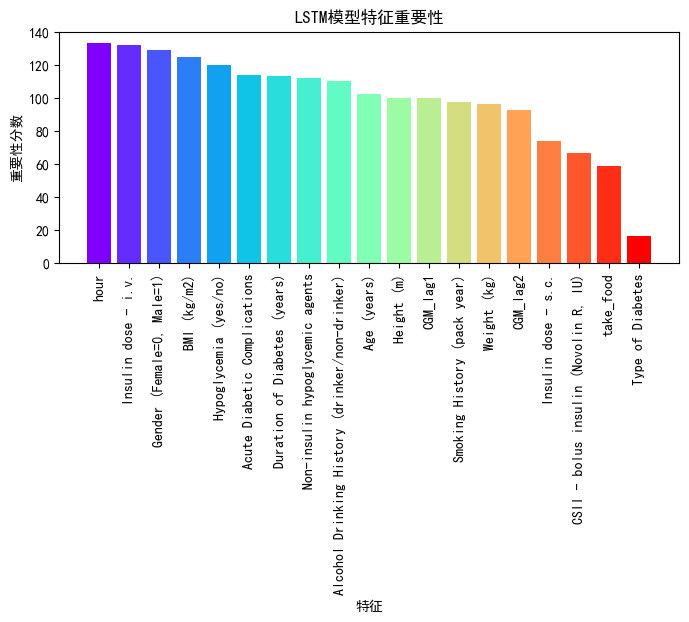

In [18]:
# 打印特征重要性
print("特征重要性：")
for feat, importance in zip(sorted_features, sorted_importance):
    print(f"{feat}: {importance:.4f}")

# 可视化特征重要性
colors = cm.rainbow(np.linspace(0, 1, len(sorted_features)))
plt.figure(figsize=(8, 3))
plt.bar( sorted_features, sorted_importance,color=colors)
plt.xlabel('特征')
plt.ylabel('重要性分数')
plt.title('LSTM模型特征重要性')
plt.xticks(rotation=90)  # 使特征名称可以清晰显示
plt.show()

特征重要性用于PPT部分到此结束

In [13]:
# 进行预测
y_pred_lstm = model.predict(X_test_lstm)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


各时间间隔的平均绝对误差:  [64.90401975 49.44814284 52.64504    61.75687657]


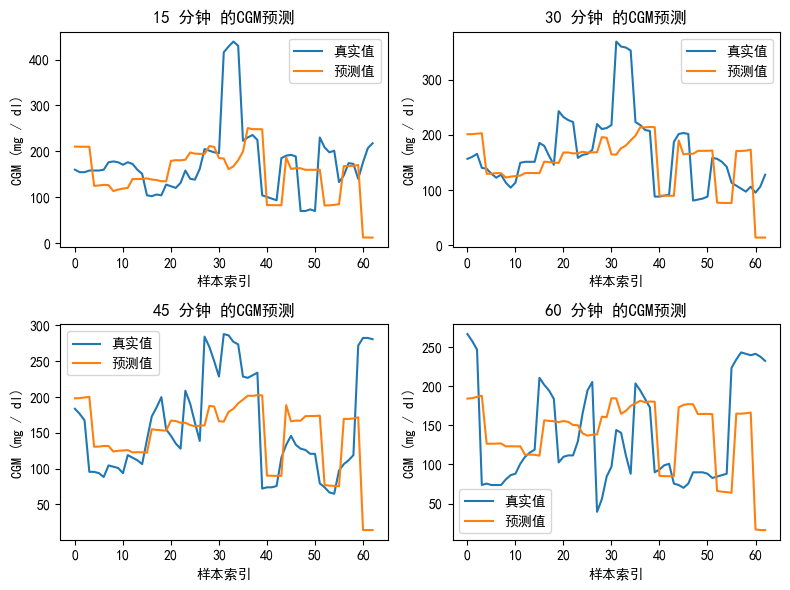

In [24]:
# 评估模型性能
mae = mean_absolute_error(y_test_lstm, y_pred_lstm, multioutput='raw_values')
print("各时间间隔的平均绝对误差: ", mae)

# 可视化预测结果
time_intervals = ['15 分钟', '30 分钟', '45 分钟', '60 分钟']
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

for i, ax in enumerate(axes.flat):
    ax.plot(y_test_lstm[:, i], label='真实值')
    ax.plot(y_pred_lstm[:, i], label='预测值')
    ax.set_title(f'{time_intervals[i]} 的CGM预测')
    ax.set_xlabel('样本索引')
    ax.set_ylabel('CGM (mg / dl)')
    ax.legend()

plt.tight_layout()
plt.show()

考虑仅选择比较重要（前8）的特征重新投入模型，获取预测水平，有时间可以先做